In [2]:
import tensorflow as tf
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
import cv2
import pathlib 
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from keras.applications import vgg19, vgg16
from sklearn.neighbors import DistanceMetric

# Methodology
- In many cases that doctors face during the different treatment processes for many patients, so that the doctor tries every time to remember an old pathological condition that he encountered in advance in order to try to retrieve the methodology that he followed at that moment to treat the patient who has the same pathological condition.
- In this study, I tried to search for the methodology by which the doctor can retrieve similar pathological conditions for a specific new case, which makes it easier for the doctor to retrieve the way he treated the old patient in order to try to propose it in solving the problem of the new patient.
- Thus, the methodology relied mainly on focusing on the basic patterns that distinguish the images included in the dataset (dataset here, we mean a list of all previous patients treated by the doctor), and working to compare those features and patterns that characterize all medical images of the chest area of previous patients with the features that Characterized by the new medical image of the new patient.
- This is what the patient does when trying to retrieve his memory to confirm a previous medical condition that he treated.
- The methodology was mainly based on the use of a conditional autoencoder, where medical images were passed to normal people and people infected with the Corona virus, and the conditional condition was used to force the autoencoder to focus on the basic features in determining the location of infection, so that the autoencoder does not focus on redrawing the basic shape of the medical images without focusing on diseased areas.
- That is, I tried through the study to focus on the basic features in determining the locations of infection with the Corona virus, and therefore I entered the normal, uninfected state during the training of the obstetric model.
- The Euclidean distance law and the Manhattan distance were used to study the distance between features.

# Read Images

In [3]:
class ReadImages:
    def __init__(self, datasetPath, image_shape):
        self.datasetPath = datasetPath
        self.image_shape = image_shape
    def ListImages(self, label):
        return list(pathlib.Path(os.path.join(self.datasetPath, label)).glob('*.*'))
    def readEachImages(self,):
        self.covidimages = self.ListImages('COVID')
        self.non_covidimamges = self.ListImages('non-COVID')
    def ImageToArray(self, listimages, label):
        images = []
        labels = []
        for img in listimages:
            img = cv2.imread(str(img))
            img = cv2.resize(img, self.image_shape)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img/255
            images.append(img)
            labels.append(label)
        return np.array(images), np.array(labels)
    def readImages(self,):
        self.readEachImages()
        covidimages, covidlabels = self.ImageToArray(self.covidimages[:600], 0)
        noncovidimages, noncovidlabels = self.ImageToArray(self.non_covidimamges[:600], 1)
        return np.vstack([covidimages, noncovidimages]), np.hstack([covidlabels, noncovidlabels])
            

In [4]:
datasetimages = ReadImages('/kaggle/input/sarscov2-ctscan-dataset', (224, 224,))
images, labels = datasetimages.readImages()

In [5]:
images.shape, labels.shape

((1200, 224, 224, 3), (1200,))

In [6]:
labels = tf.keras.utils.to_categorical(labels)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size = 0.1, 
                                                stratify = labels, random_state = 1)

In [8]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((1080, 224, 224, 3), (120, 224, 224, 3), (1080, 2), (120, 2))

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


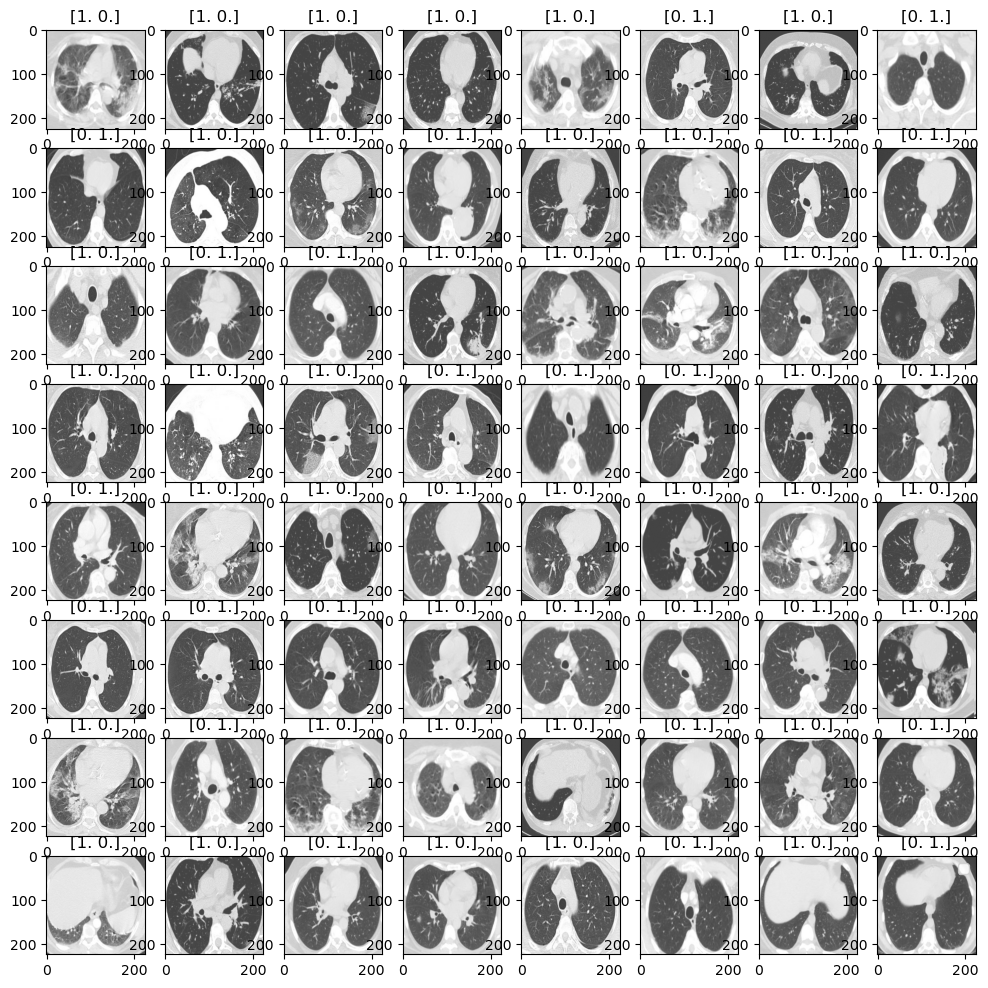

In [9]:
plt.figure(figsize = (12, 12))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(xtrain[i])
    plt.title(ytrain[i])
plt.legend()

# AutoEncoder (Encoder + Decoder)

In [15]:
latent_space = 128
basemodel = vgg19.VGG19(weights = 'imagenet', include_top = False, pooling = None, 
                       input_shape = (224, 224, 3))
x = layers.BatchNormalization()(basemodel.output)
input_labels = layers.Input(shape = (2, ))
x_labels = layers.Dense(7*7*512, kernel_regularizer = tf.keras.regularizers.L2(0.0001),
                       )(input_labels)
x_labels = layers.Reshape((7, 7, 512))(x_labels)
x_labels = layers.BatchNormalization()(x_labels)
x = layers.concatenate([x, x_labels])
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(latent_space, name = 'latent_space', 
                kernel_regularizer = tf.keras.regularizers.L2(0.0001))(x)
encoder = tf.keras.models.Model(inputs = [basemodel.input, input_labels], outputs = x)
for layer in encoder.layers[:12]:
    layer.trainable = False
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

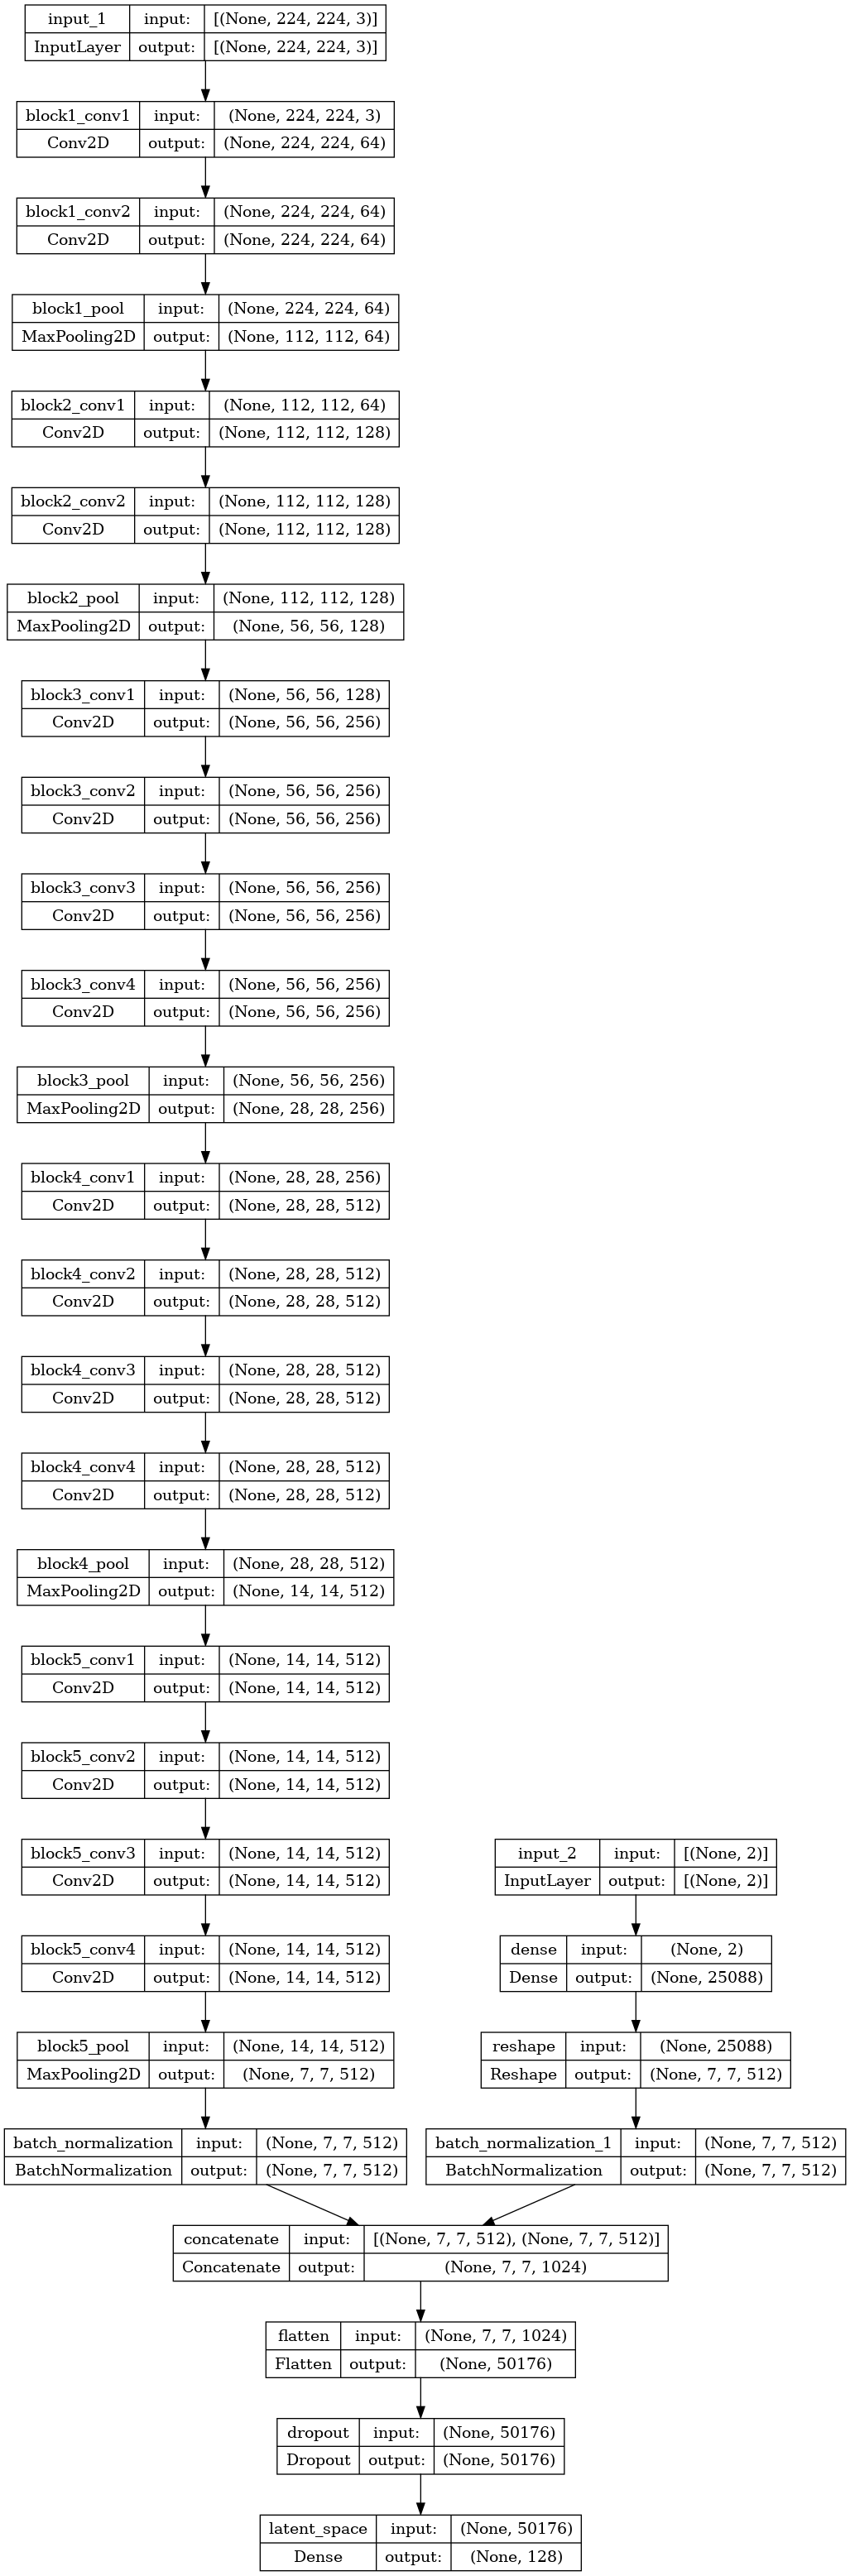

In [12]:
tf.keras.utils.plot_model(encoder, show_shapes = True)

In [16]:
filters = [512, 512, 256, 128, 64]
kernel_size = 3
padding = 'same'
strides = 2
act = 'relu'
decoder_input = layers.Input(shape = (latent_space, ))
input_labels = layers.Input(shape = (2, ))
x = layers.Dense(7*7*512,)(decoder_input)
labels_x = layers.Dense(7*7*512)(input_labels)
input = layers.average([x, labels_x])
x = layers.Reshape((7, 7, 512))(input)
for filter in filters:
    x = layers.Conv2DTranspose(filter, kernel_size, padding = padding, strides = strides, 
                              )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act)(x)
    x = layers.Dropout(0.4)(x)
x = layers.Conv2DTranspose(3, kernel_size, padding = padding, strides = 1, activation = 'sigmoid')(x)
decoder = tf.keras.models.Model(inputs = [decoder_input, input_labels], 
                              outputs = x)
decoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 25088)        3236352     ['input_7[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 25088)        75264       ['input_8[0][0]']                
                                                                                            

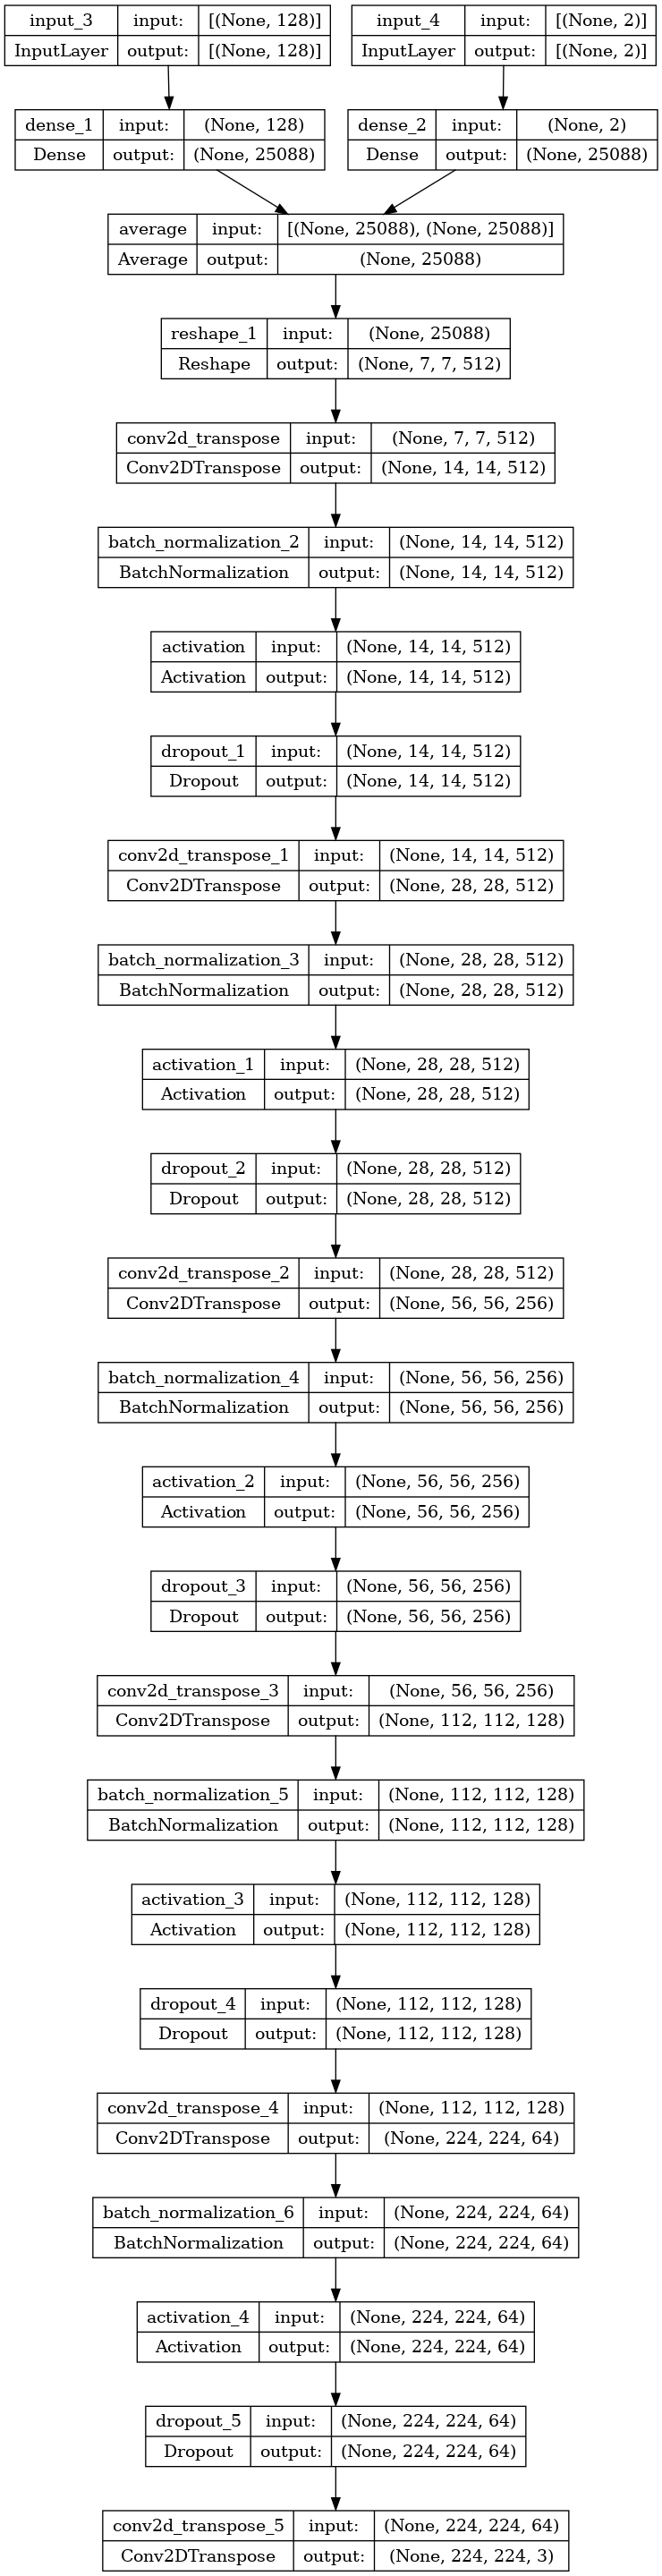

In [14]:
tf.keras.utils.plot_model(decoder, show_shapes = True)

In [17]:
autoencoder = tf.keras.models.Model(inputs = [basemodel.input, input_labels], 
                                    outputs = decoder([encoder([basemodel.input, input_labels]), input_labels]))
autoencoder.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))
autoencoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 model_3 (Functional)           (None, 128)          26526400    ['input_5[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                            

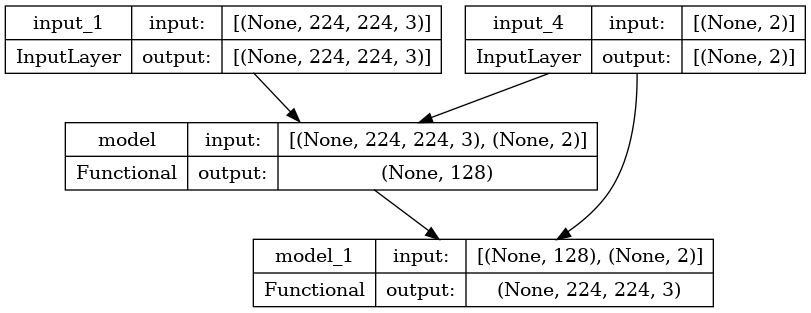

In [16]:
tf.keras.utils.plot_model(autoencoder, show_shapes = True)

In [18]:
history = autoencoder.fit([xtrain, ytrain], 
                          xtrain, validation_data = ([xtest, ytest], xtest), 
                         epochs = 60, batch_size = 2, callbacks = [
                             tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss', 
                                                             mode = 'min', restore_best_weights = True),
                         ])

Epoch 1/60


2023-05-31 20:03:16.942655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/model_4/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


540/540 [==============================] - 35s 47ms/step - loss: 0.0478 - val_loss: 0.0373
Epoch 2/60
540/540 [==============================] - 25s 46ms/step - loss: 0.0394 - val_loss: 0.0658
Epoch 3/60
540/540 [==============================] - 25s 46ms/step - loss: 0.0376 - val_loss: 0.0458
Epoch 4/60
540/540 [==============================] - 25s 45ms/step - loss: 0.0345 - val_loss: 0.0320
Epoch 5/60
540/540 [==============================] - 25s 46ms/step - loss: 0.0318 - val_loss: 0.0300
Epoch 6/60
540/540 [==============================] - 25s 46ms/step - loss: 0.0296 - val_loss: 0.0292
Epoch 7/60
540/540 [==============================] - 24s 45ms/step - loss: 0.0277 - val_loss: 0.0277
Epoch 8/60
540/540 [==============================] - 25s 46ms/step - loss: 0.0267 - val_loss: 0.0267
Epoch 9/60
540/540 [==============================] - 25s 46ms/step - loss: 0.0254 - val_loss: 0.0237
Epoch 10/60
540/540 [==============================] - 25s 46ms/step - loss: 0.0243 - val_los

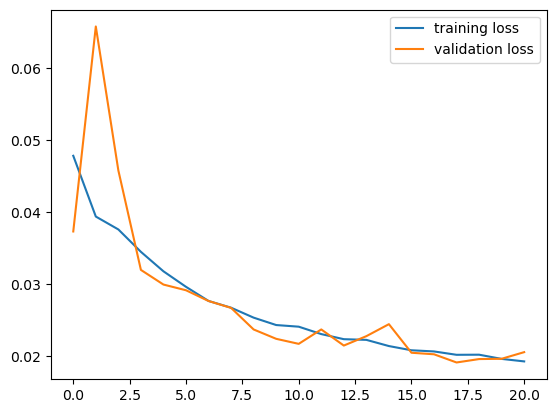

In [19]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [20]:
autoencoder.evaluate([xtest, ytest], xtest, batch_size = 2)

60/60 [==============================] - 1s 16ms/step - loss: 0.0191


0.019142497330904007

In [21]:
autoencoder.evaluate([xtrain, ytrain], xtrain, batch_size = 2)

540/540 [==============================] - 9s 16ms/step - loss: 0.0183


0.018289407715201378

In [22]:
pred = autoencoder.predict([xtest, ytest])
pred.shape

4/4 [==============================] - 6s 806ms/step


(120, 224, 224, 3)

> We can see the result by reviewing a number of medical images of cases that are not infected with the Corona virus, and other cases infected with the Corona virus, and thus we notice that the neural network focused mainly on the basic features in identifying pathological conditions, which we see through the degree of opacity.

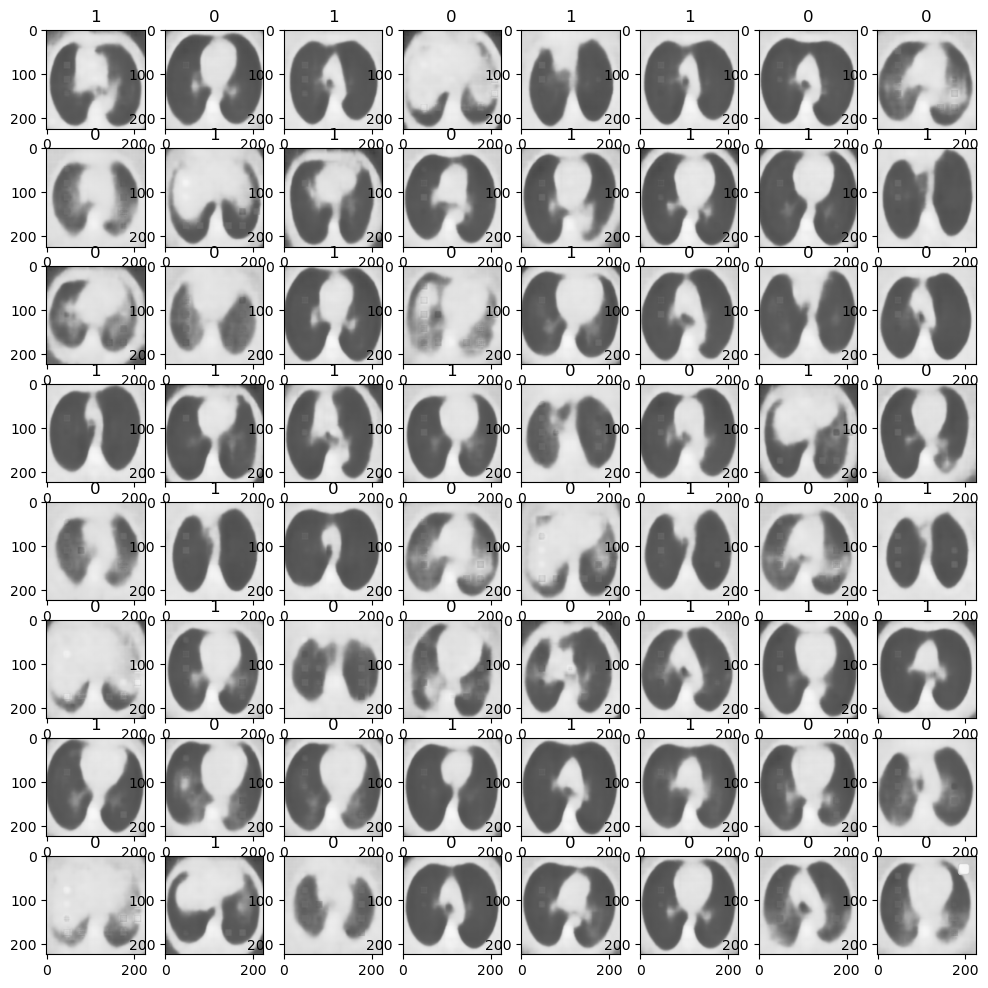

In [23]:
plt.figure(figsize = (12, 12))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(pred[i])
    plt.title(np.argmax(ytest[i]))
plt.legend()

In [24]:
newDataset = {
    'features': encoder.predict([images, labels]),
    'images': images,
    'labels': labels
}

38/38 [==============================] - 4s 104ms/step


In [33]:
class SimilarFeatures:
    def __init__(self, dataset, maxSimilar, distancMetric):
        self.dataset = dataset
        self.maxSimilar = maxSimilar
        self.distancMetric = distancMetric
    def ecludian_distance(self, firstFeatures, secondFeatures):
        if self.distancMetric == 'euclidean':
              return np.linalg.norm(firstFeatures - secondFeatures)
        elif self.distancMetric == 'manhattan':
              return np.sum(np.abs(firstFeatures - secondFeatures))
    def searchByFeatures(self, singleFeatures, orginalLabel):
        AllDataset = range(len(self.dataset['features']))
        results = []
        for i in AllDataset:
            if np.argmax(orginalLabel) == np.argmax(self.dataset['labels'][i]):
                distance = self.ecludian_distance(singleFeatures, self.dataset['features'][i])
                results.append([distance, self.dataset['images'][i],
                               self.dataset['labels'][i]])
        return sorted(results, key= lambda res: res[0])[:self.maxSimilar]
    def showResult(self, imagesSimilar, distanceSimilar, labelsSimilar):
        plt.figure(figsize = (12, 4))
        for i in range(self.maxSimilar):
            plt.subplot(2, 9, (i + 1))
            plt.imshow(imagesSimilar[i])
            plt.title('d: {},y: {}'.format(int(distanceSimilar[i]), 
                                           np.argmax(labelsSimilar[i])))
        plt.legend()

# Model test: (search for similar medical conditions):

In [30]:
def showSamplesOfResults(imageIndex, similar_features_object, encoder):
    results = similar_features_object.searchByFeatures(encoder.predict([xtest[imageIndex - 1:imageIndex], 
                                                                    ytest[imageIndex - 1:imageIndex]]), 
                                                                    np.squeeze(ytest[imageIndex - 1:imageIndex]))
    plt.imshow(np.squeeze(xtest[imageIndex - 1:imageIndex]))
    plt.title(np.argmax(ytest[imageIndex - 1:imageIndex]))
    similar_features_object.showResult([res[1] for res in results], 
                                      [res[0] for res in results],
                                      [res[2] for res in results])

## Euclidean distance Example

- In this section, we will review a large number of examples that were presented as a result of the search for medical images similar to the basic image that you want to search for similar images for.
- In a number of these examples, the Euclidean distance was used to study the distance between features, and in other examples, the Manhattan distance was used.
- We notice that the two scales are close to each other, in being able to determine the degree of similarity.
- The results obtained were arranged in ascending order according to the degree of similarity, the smaller the value, the higher the similarity degree.

In [34]:
similar_features_object = SimilarFeatures(newDataset, 18, 'euclidean')

1/1 [==============================] - 0s 22ms/step


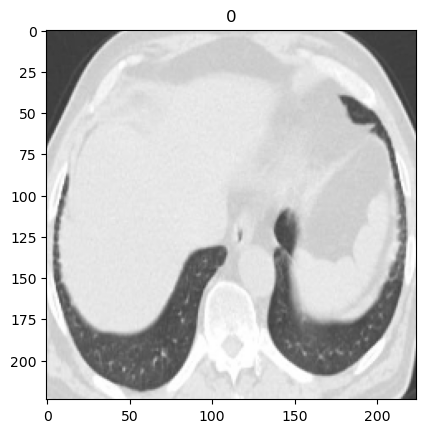

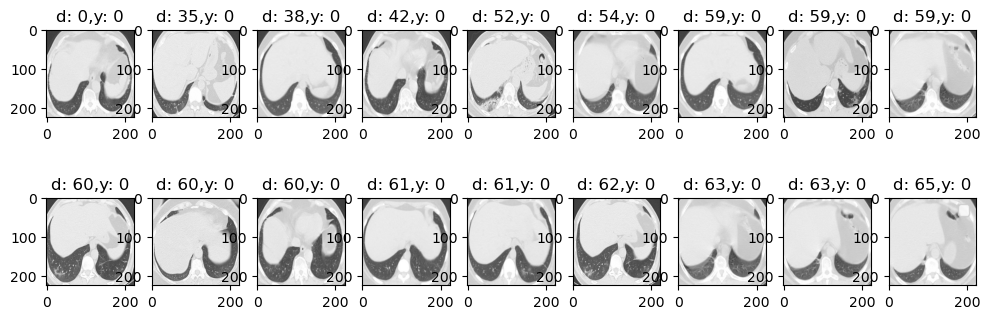

In [35]:
showSamplesOfResults(4, similar_features_object, encoder)

## Manhattan distance Example

In [40]:
similar_features_object_manhattan = SimilarFeatures(newDataset, 18, 'manhattan')

1/1 [==============================] - 0s 22ms/step


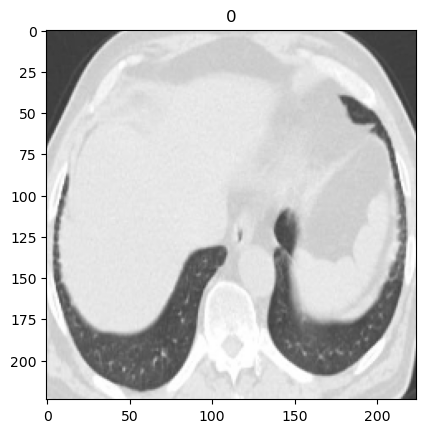

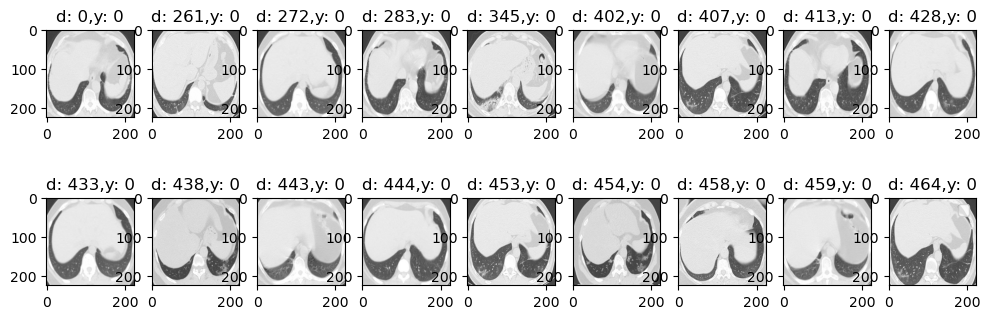

In [41]:
showSamplesOfResults(4, similar_features_object_manhattan, encoder)

## Euclidean distance Example

1/1 [==============================] - 0s 23ms/step


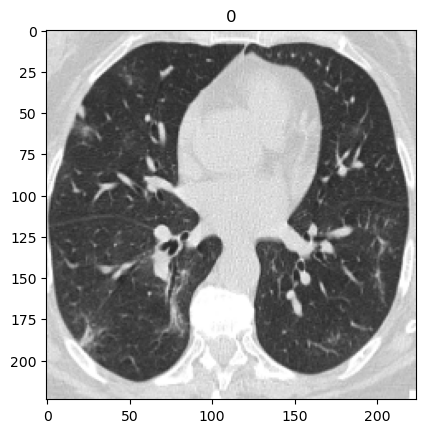

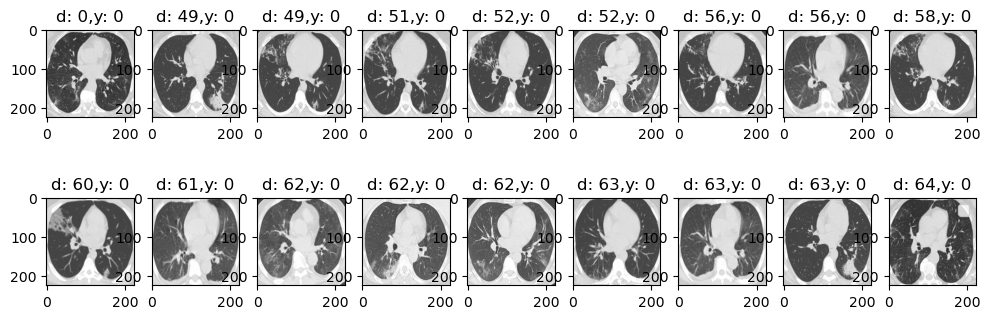

In [42]:
showSamplesOfResults(2, similar_features_object, encoder)

## Manhattan distance Example

1/1 [==============================] - 0s 20ms/step


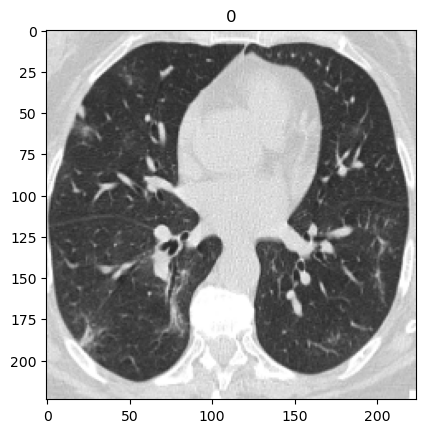

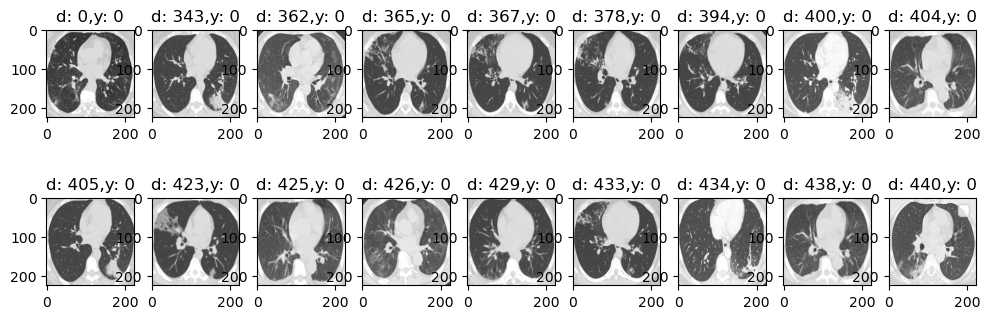

In [43]:
showSamplesOfResults(2, similar_features_object_manhattan, encoder)

## Euclidean distance Example

1/1 [==============================] - 0s 19ms/step


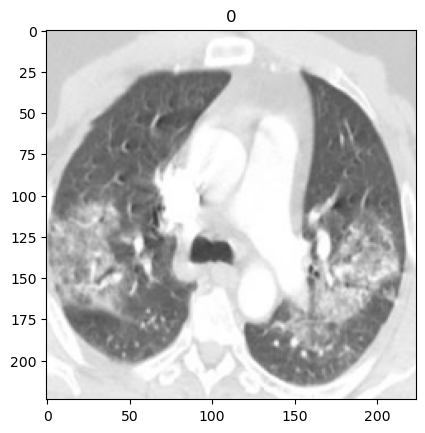

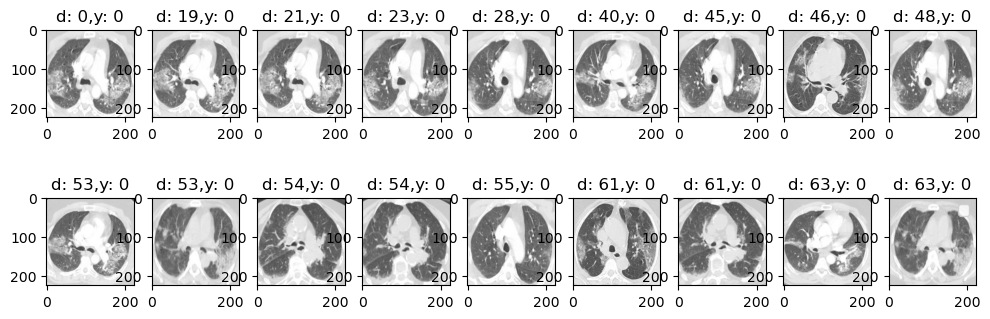

In [44]:
showSamplesOfResults(8, similar_features_object, encoder)

## Manhattan distance Example

1/1 [==============================] - 0s 19ms/step


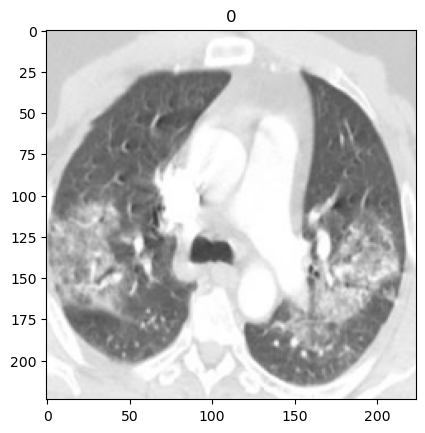

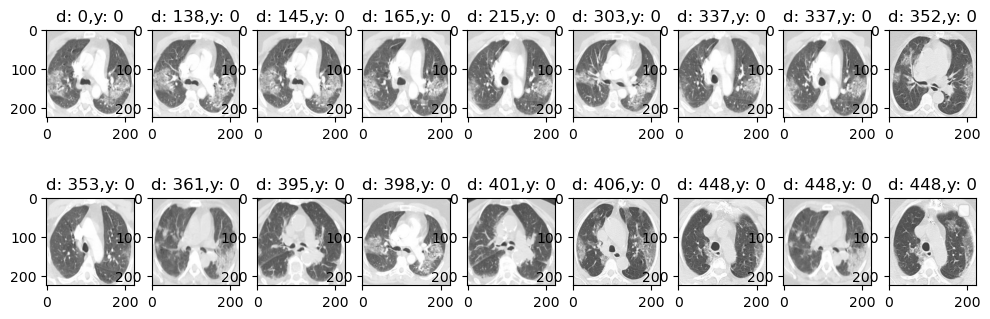

In [45]:
showSamplesOfResults(8, similar_features_object_manhattan, encoder)

## Euclidean distance Example

1/1 [==============================] - 0s 46ms/step


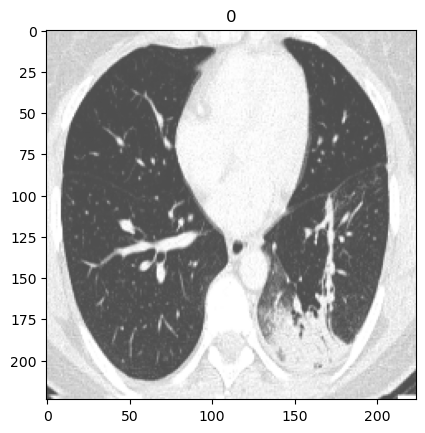

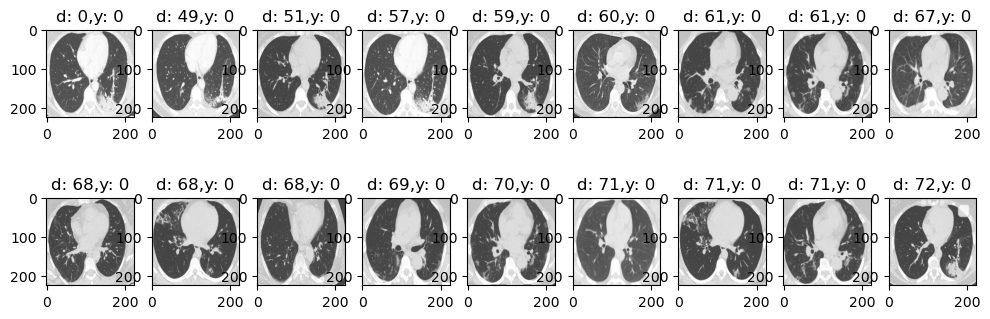

In [46]:
showSamplesOfResults(32, similar_features_object, encoder)

1/1 [==============================] - 0s 21ms/step


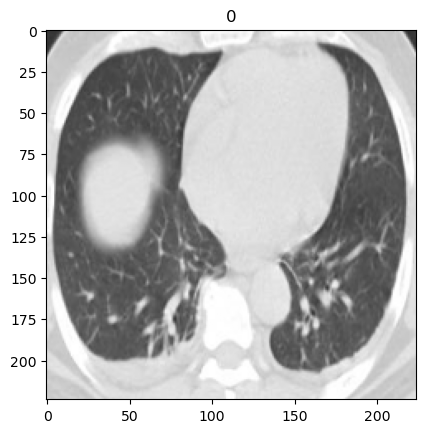

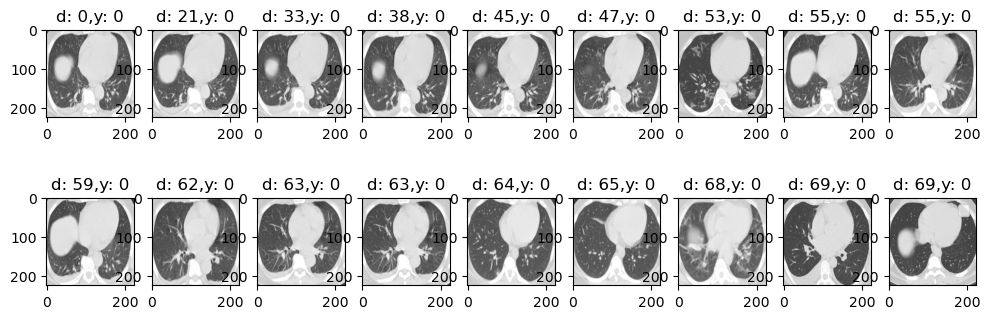

In [47]:
showSamplesOfResults(50, similar_features_object, encoder)

> The next methodology (which I will add soon) is to work on focusing on the basic features in determining the locations of infection with the Corona virus, and this is done by studying the convergence effect of the weights of the convolutional layers (that is, I will work on deriving the prediction value based on the weights from Order each convolutional layer and compare it with the derivative values for each image in the dataset to determine the hit result.